# Exploratory data analysis

Let's perform some exploratory data analysis to get a sense of what we have to work with in our PitchFX database. We'll do this by producing a number of plots to visually inspect our data.

To start, we will link relevant libraries.

In [1]:
# imports
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
%matplotlib inline

## Importing database

We'll first want to connect to our database. I've already created a PitchFX database for the year 2008 using a framework introduced in *read_data.ipynb*, and I will connect to it here. You will want to change `dbname` to the path of your personal database.

In [2]:
# specify database name
dbname = "../dat/pitchfx2008.db"

# connect to the sqlite3 database
db = sqlite3.connect(dbname)
hdb = db.cursor()

## Tables and features

Let's take a look at the tables and the corresponding features associated with those tables. Here are the table names.

In [3]:
# table names
query = """SELECT name FROM sqlite_master WHERE type='table'"""
hdb.execute(query)
table_names = hdb.fetchall()
print(*table_names)

('games',) ('teams',) ('stadiums',) ('players',) ('umpires',) ('events',) ('pitchfx',)


As we can see, there are a number of tables at our disposal. Let's now look at the features in each of these tables.

In [4]:
for tt in table_names:
    query = "SELECT * FROM %s" %(tt[0])
    names = [description[0] for description in hdb.execute(query).description]
    print("%s\n %s\n" %(tt[0], names))

games
 ['game_id', 'game_type', 'date', 'game_time', 'home_id', 'visit_id', 'home_wins', 'home_losses', 'visit_wins', 'visit_losses', 'stadium_id', 'umpire_home', 'umpire_first', 'umpire_second', 'umpire_third']

teams
 ['team_id', 'team_name', 'team_abbr']

stadiums
 ['stadium_id', 'stadium_name']

players
 ['player_id', 'player_first', 'player_last', 'position', 'bats', 'throws', 'dob']

umpires
 ['umpire_id', 'umpire_name']

events
 ['game_id', 'event_id', 'event_description', 'inning', 'is_top_inning', 'pre_out', 'post_out', 'pitcher_id', 'batter_id', 'runner_id', 'run_start', 'run_end', 'home_score', 'away_score']

pitchfx
 ['game_id', 'pitch_num', 'at_bat', 'time', 'prev_event', 'description', 'outcome', 'pre_balls', 'post_balls', 'pre_strike', 'post_strike', 'start_speed', 'end_speed', 'sz_top', 'sz_bot', 'pfx_x', 'pfx_z', 'px', 'pz', 'x', 'y', 'x0', 'y0', 'z0', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'break_y', 'break_angle', 'break_length', 'spin_dir', 'spin_rate', 'pitch_type'

As we can see, there are a number of tables that can be linked together. Because we are going to be interested in working with the *pitchfx* and the *events* tables. The former table contains all the pitch trajectory and location information and contains most of the important numeric data, while the latter table ties those pitches to in-game events.

## Pitch types

Let's look more at the types of pitches classified by the database.

### Pitch frequency

Let's first take a look at what classifications pitches can have by looking at the `pitch_type` feature. We'll create a bar chart of all pitch classifications to get a sense of the distribution of pitches.

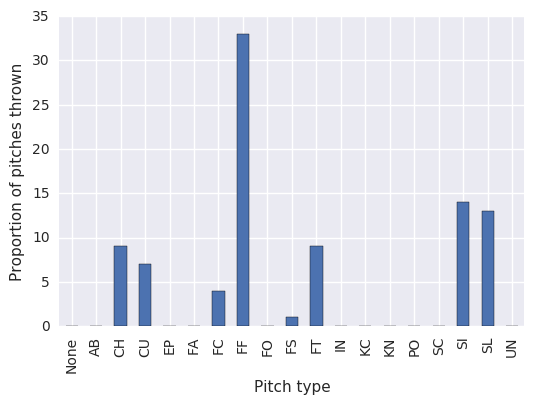

In [5]:
# grab pitch_type information
query = """SELECT pitch_type, 100*COUNT(pitch_type)/(SELECT COUNT(*) FROM pitchfx)
        FROM pitchfx
        GROUP BY pitch_type"""
ptype = pd.read_sql_query(query, db)

# plot histogram of pitch classifications
fig, ax = plt.subplots()
ptype.iloc[:, 1].plot.bar()
ax.set_xticklabels(ptype["pitch_type"])
ax.set_xlabel("Pitch type")
ax.set_ylabel("Proportion of pitches thrown")
plt.show()

A guide to the pitch classifications provided by the database can be found at https://www.fangraphs.com/library/pitch-type-abbreviations-classifications/. As we can see the four-seam fastbal (FF) is buy far the most common pitch amongst pitchers, thrown over 35% of the time. The next two common pitches are sinkers (SI) and sliders (SL) at around 13%, followed by the two-seam fastball (FT) and change-up (CH) around 9%. The next common pitches are the curveball (CU) and the cut-fastball (FC).

### Four-seam fastball velocity variation

Since four-seam fastballs are the most common pitch, let's look at how much they vary from pitcher to pitcher. First we'll compare the starting velocities of all fastballs from all pitchers in a histogram.

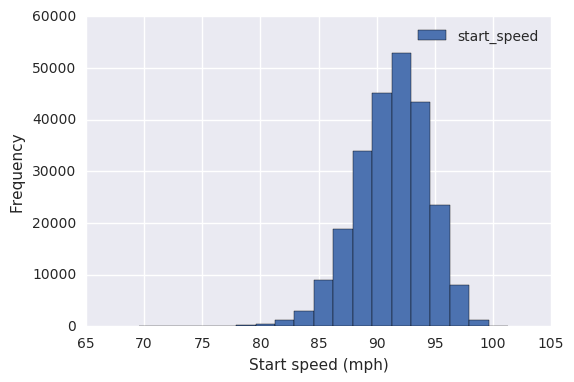

In [6]:
# get fastball information
query = """SELECT start_speed
        FROM pitchfx
        WHERE pitch_type='FF'"""
ff_speed = pd.read_sql_query(query, db)

# histogram of velocities
ff_speed.plot.hist(bins=20)
plt.xlabel("Start speed (mph)")
plt.show()

As we can see, most of the four-seams sit at 92-93 mph. Let's see how different the speeds are between left-handed and right-handed pitchers. To do this, we will need to join multiple tables, as the handedness of the pitcher is in the *player* table and the *events* table is needed to tie the pitcher to the pitch. We will then plot histograms for both handednesses in the same plot.

In [7]:
# left handers
query = """SELECT start_speed
        FROM pitchfx
        JOIN events ON (pitchfx.game_id=events.game_id
            AND pitchfx.prev_event=events.event_id)
        JOIN players ON (events.pitcher_id=players.player_id)
        WHERE pitchfx.pitch_type='FF'
            AND players.throws='L'"""
ff_speedL = pd.read_sql_query(query, db)

# right handers
query = """SELECT start_speed
        FROM pitchfx
        JOIN events ON (pitchfx.game_id=events.game_id
            AND pitchfx.prev_event=events.event_id)
        JOIN players ON (events.pitcher_id=players.player_id)
        WHERE pitchfx.pitch_type='FF'
            AND players.throws='R'"""
ff_speedR = pd.read_sql_query(query, db)

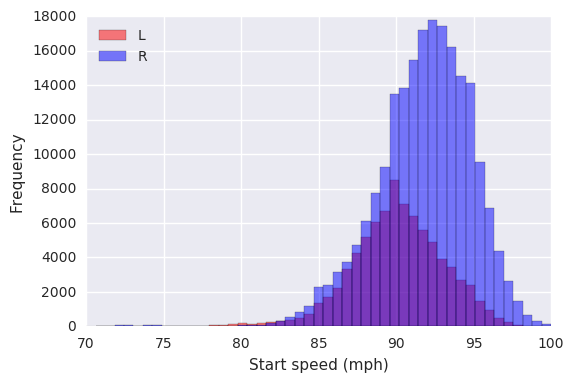

In [8]:
# plot histograms on top of each other
bins = np.linspace(70, 100, 50)
plt.hist(ff_speedL.as_matrix(), bins=bins, alpha=0.5, label='L', color='R')
plt.hist(ff_speedR.as_matrix(), bins=bins, alpha=0.5, label='R', color='B')
plt.legend(loc='upper left')
plt.xlabel("Start speed (mph)")
plt.ylabel("Frequency")
plt.show()

We see that, in general, left handers have slower four-seamers than right handers. This could be because left handers are less populous than right handers, so finding left-handers who can throw hard is difficult. Let's view the same data in boxplots.

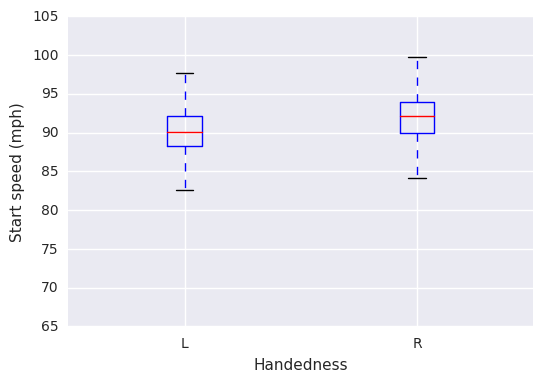

In [9]:
# plot boxplots of velocity by handedness
plt.boxplot([ff_speedL, ff_speedR], labels=['L', 'R'])
plt.xlabel("Handedness")
plt.ylabel("Start speed (mph)")
plt.show()

We can say clearly that median velocity of four-seamers is slower for left handers than for right handers. This partially explains why hard-throwing left handers are coveted by teams: they're rare.

### Slider movement

Previously, we saw that the four-seamer can vary significantly from pitcher to pitcher. Four-seamers typically have relatively little movement. Here, we'll look at the most common breaking pitch, which is the slider. Since sliders have a lot of movement, we expect to see variations in not only velocity, but also horizontal and vertical movement.

Because sliders break differently depending on handedness, we will start by focusing on sliders thrown by righties. In addition to the starting speed, we will also grab the horizontal and vertical movements (in inches), as well as spin rate. We choose these parameters based on human intution.

In [10]:
query = """SELECT start_speed, pfx_x, pfx_z, spin_rate
        FROM pitchfx
        JOIN events ON (pitchfx.game_id=events.game_id
            AND pitchfx.prev_event=events.event_id)
        JOIN players ON (events.pitcher_id=players.player_id)
        WHERE pitchfx.pitch_type='SL'
            AND players.throws='R'"""
sl_speed_move = pd.read_sql_query(query, db)

Let's take a look at density plots of sliders in horizontal and vertical movement space.

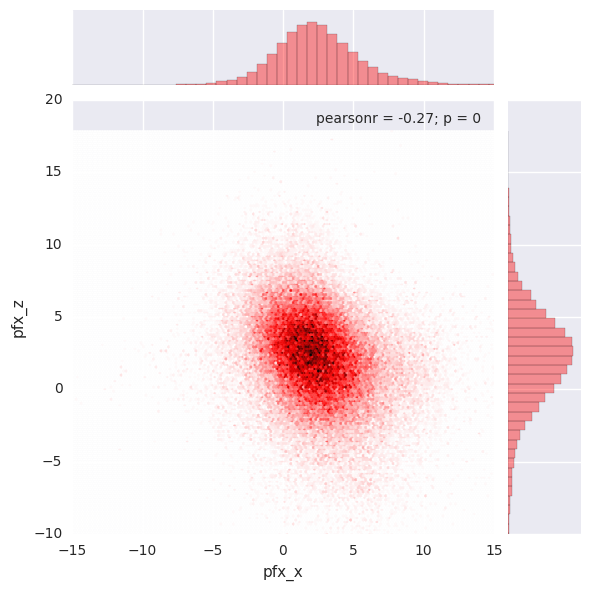

In [11]:
# create density plot of accelerations
sns.jointplot(sl_speed_move["pfx_x"],
              sl_speed_move["pfx_z"],
              color="red",
              kind="hex",
              xlim=[-15, 15],
              ylim=[-10, 20],)
plt.show()

Let's compare the spread in movement in the slider to those in the four-seamer.

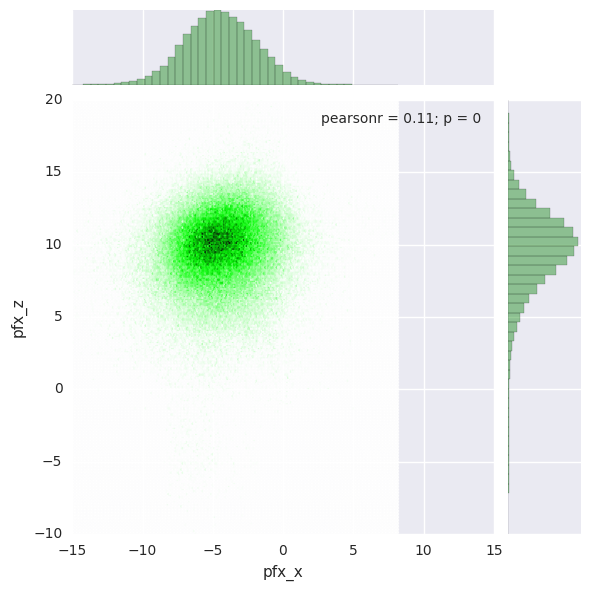

In [12]:
query = """SELECT start_speed, pfx_x, pfx_z, spin_rate
        FROM pitchfx
        JOIN events ON (pitchfx.game_id=events.game_id
            AND pitchfx.prev_event=events.event_id)
        JOIN players ON (events.pitcher_id=players.player_id)
        WHERE pitchfx.pitch_type='FF'
            AND players.throws='R'"""
ff_speed_move = pd.read_sql_query(query, db)

# create density plot of accelerations
sns.jointplot(ff_speed_move["pfx_x"],
              ff_speed_move["pfx_z"],
              color="green",
              kind="hex",
              xlim=[-15, 15],
              ylim=[-10, 20],)
plt.show()

We can visually see that the spread in movements in the horizontal and vertical directions are smaller for the four-seamer than the slider. This result suggests that sliders come in more flavors than four-seamers. Some sliders may have more horizontal break than others, while some sliders may have more vertical break than others. Note that these results assume that the labels from the database are "correct".

Additionally, we can see that four-seamers and sliders have very different trajectories. These plots suggests that we may be able to separate pitch types based on the numerical features in our database.

### Pitch separation

We should be able to separate pitches in feature space given how different each of these pitches are. Let's look at crossplots of movements, velocity, and given pitch classifications and see if the can visually be separated. We'll look at left-handers first to see if pitches might be separable.

In [13]:
# grab pitchfx table for right handers
query = """SELECT pitchfx.*
        FROM pitchfx
        JOIN events ON (pitchfx.game_id=events.game_id
            AND pitchfx.prev_event=events.event_id)
        JOIN players ON (events.pitcher_id=players.player_id)
        WHERE players.throws='L'"""
pitchfxL = pd.read_sql_query(query, db)

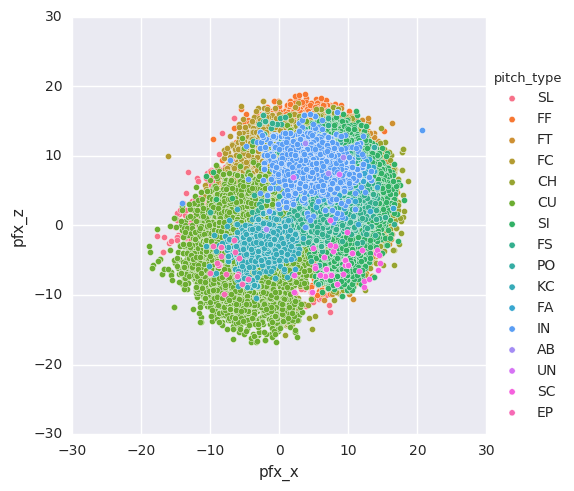

In [46]:
# plot crossplot over movements
sns.pairplot(x_vars="pfx_x",
             y_vars="pfx_z",
             data=pitchfxL,
             hue="pitch_type",
             size=5,)
plt.xlim(-30, 30)
plt.ylim(-30, 30)
plt.show()

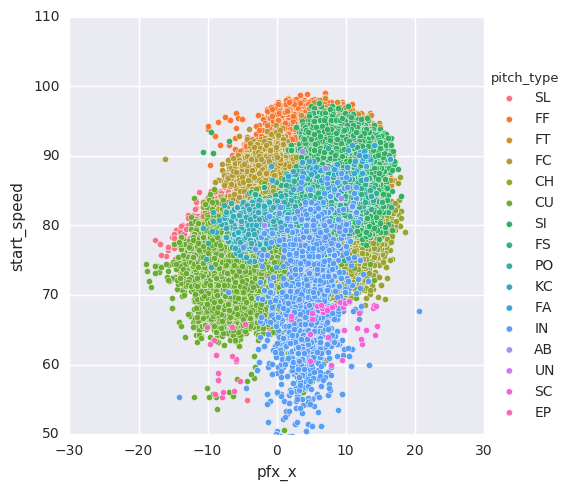

In [47]:
# plot crossplot over horizontal movement and velocity
sns.pairplot(x_vars="pfx_x",
             y_vars="start_speed",
             data=pitchfxL,
             hue="pitch_type",
             size=5,)
plt.xlim(-30, 30)
plt.ylim(50, 110)
plt.show()

From these plots, we can see why general pitch classification is a difficult task. The left-handed pitches do not cluster cleanly based on these particular subset of features. As we have seen, not every slider is the same, not every curveball is the same, and not every fastball is the same. Therefore, it'll be useful to look at a specific pitcher in order to classify pitches based solely on trajectory information.

## Single pitcher pitch trajectories

Let's look at a single pitcher. Here, we'll choose Barry Zito, a soft-throwing left hander with a big curveball. We'll get his pitch information from the database first.

In [32]:
# get BZ's information
query = """SELECT DISTINCT pitchfx.* 
        FROM pitchfx
        JOIN events ON (pitchfx.game_id=events.game_id
            AND pitchfx.prev_event=events.event_id)
        WHERE events.pitcher_id=(SELECT player_id
            FROM players
            WHERE players.player_first='Barry'
                AND players.player_last='Zito')
        ORDER BY game_id, pitch_num"""
bz_pfx = pd.read_sql_query(query, db)

### Data cleaning

Let's first look for Nans in this particular dataframe. We'll a matrix of zeros except for where the Nans are.

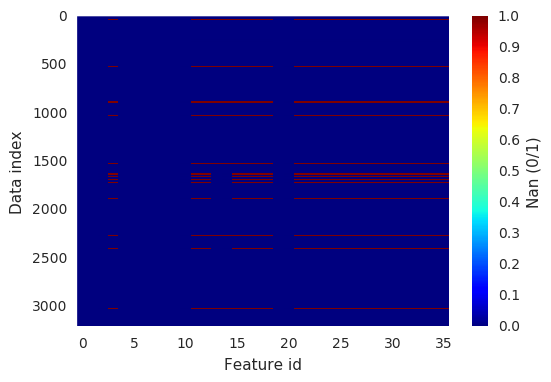

fraction of data points containing Nans:  0.032439176544


In [33]:
# view rows containing Nans
inans = bz_pfx.isnull()
plt.imshow(inans,
          aspect='auto',
          cmap="jet",
          interpolation='none',)
plt.xlabel('Feature id')
plt.ylabel('Data index')
plt.grid(False)
plt.colorbar(label="Nan (0/1)")
plt.show()

# fraction containing Nans
print("fraction of data points containing Nans: ", np.sum(inans.any(axis=1))/len(inans))

Based on the indices of the Nans in the data matrix, it seems that if a data point contains Nans, then the Nans are found across multiple features. Additionally, the rows containing Nans seem to be spread out across the data index. Therefore, it seems unlikely that there is a systematic pattern in where there are Nans.

Because only 3% of the data points contain Nans, and because there does not seem to be a systematic pattern in when the Nans occur, we will drop these pitches from the data frame rather than using imputation.

In [34]:
# drop Nans from pitch_info
bz_pfx = bz_pfx.dropna(axis=0, how="any")

### Scatter matrix and correlated features

We will also remove features that are used for indexing (`game_id`, `pitch_num`, `at_bat`, `time`, and `prev_event`) and also categorical features (`outcome`, `description`, and `pitch_type`).

In [35]:
# remove features
bz_pfxc = bz_pfx.drop(["game_id",
                       "pitch_num",
                       "at_bat",
                       "time",
                       "prev_event",
                       "description",
                       "outcome",
                       "pitch_type"], 1)

Now we'll by looking at a scatter matrix of variables in the *pitchfx* table. We'll look at only his first 500 pitches because it will take a while to run.

/opt/conda/lib/python3.5/site-packages/matplotlib/axes/_base.py:2782: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=50.0, right=50.0
  'left=%s, right=%s') % (left, right))
/opt/conda/lib/python3.5/site-packages/matplotlib/axes/_base.py:3040: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=50.0, top=50.0
  'bottom=%s, top=%s') % (bottom, top))


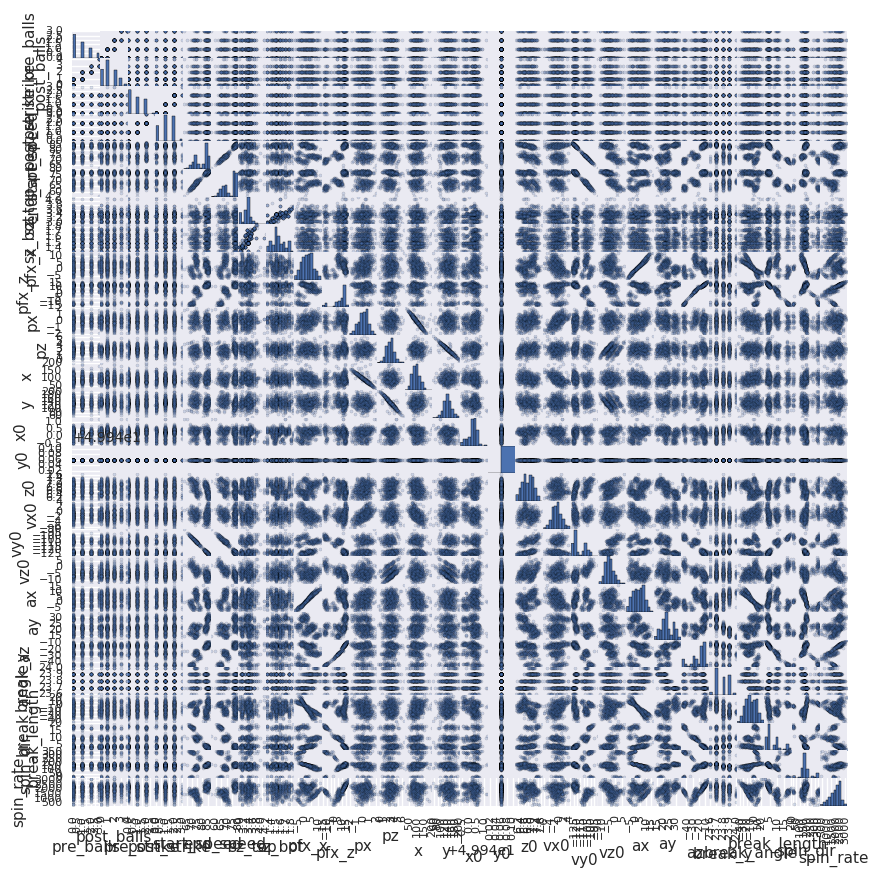

In [21]:
# create scatter matrix of numerical features
pd.scatter_matrix(bz_pfxc.iloc[:500, :],
                  alpha=0.2,
                  figsize=(10, 10),)
plt.show()

As we can see, some combinations of features that reveal interesting information. First, there appear to be clusters in some of the panels (e.g., `start_speed` and `pfx_x`, and `start_speed` and `pfx_z`). We also see that `y0` (the distance in feet from home plate where the PITCHf/x system is set to measure the initial parameters) is constant. Additionally, there are a number of highly-correlated features (e.g., `x` and `px`).

Let's take a look at the correlations between pairs of features by computing a correlation matrix (we remove `y0` from the data to clean up the correlation matrix).

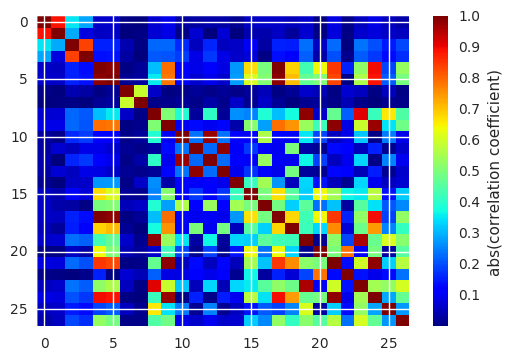

In [36]:
# visualize correlation matrix
bz_pfxc = bz_pfxc.drop(["y0"], 1)
pcorr = np.corrcoef(bz_pfxc.T)
plt.imshow(abs(pcorr),
           aspect='auto',
           cmap="jet",
           interpolation="none",)
plt.colorbar(label="abs(correlation coefficient)")
plt.show()

We can see that a number of features have very high correlation coefficients, even off of the diagonal. Let's take a closer look at the features that have (absolute values of) correlation coefficients over 0.975.

In [37]:
# find features with high correlation
hcorr = np.argwhere(np.logical_and(abs(pcorr)>0.975, pcorr!=1))

# convert indices to features
for ii in hcorr:
    print(bz_pfxc.columns[ii[0]], bz_pfxc.columns[ii[1]],)

start_speed end_speed
start_speed vy0
end_speed start_speed
end_speed vy0
pfx_x ax
pfx_z az
px x
pz y
x px
y pz
vy0 start_speed
vy0 end_speed
ax pfx_x
az pfx_z
az break_length
break_length az


So now we have a list of features that have redundant information. Not surprisingly, features related to speed are highly correlated, while features related to movement are also correlated.

### Pitch separation

Let's give pitch separation another try, this time focusing on only one pitcher instead of all pitchers. As before, we'll create crossplos of movements, velocity, and given pitch classifications and see if the can visually be separated.

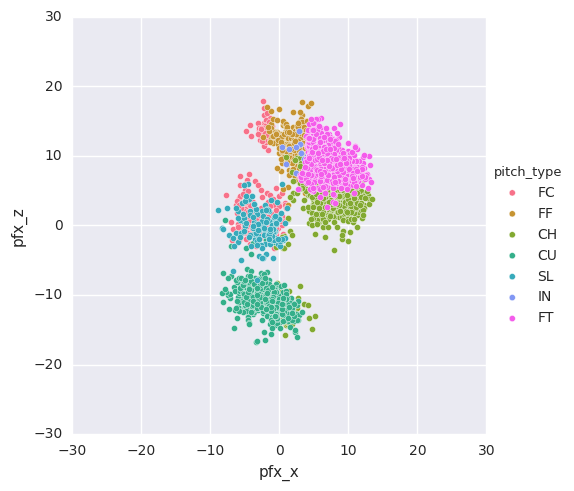

In [44]:
# plot crossplot over movements
sns.pairplot(x_vars="pfx_x",
             y_vars="pfx_z",
             data=bz_pfx,
             hue="pitch_type",
             size=5,)
plt.xlim(-30, 30)
plt.ylim(-30, 30)
plt.show()

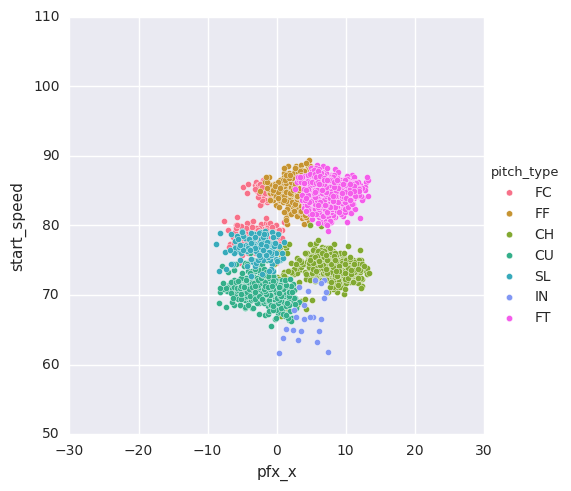

In [45]:
# plot crossplot over horizontal movement and velocity
sns.pairplot(x_vars="pfx_x",
             y_vars="start_speed",
             data=bz_pfx,
             hue="pitch_type",
             size=5,)
plt.xlim(-30, 30)
plt.ylim(50, 110)
plt.show()

Now we can see clearer separation between apparent pitch clusters, particularly when looking at speed against horizontal movement. However, we can see that while the clustering is pretty clear, there are some issues classifying the cutter, as it is group with both the fastballs (FF and FT) and the slider (SL).

Thus, if we want to work with pitch labels, it may be a good idea to try to classify pitches ourselves, potentially via a clustering method.

## Dimensionality reduction

We saw previously that a number of features are highly correlated. There are a number of ways we can reduce high-dimensional data into fewer dimensions that are still representative of the data. Principal component analysis (PCA) allows us to summarize this set with a smaller number of representative variables that collectively explain most of the variability in the original set

PCA aims to perform feature extraction by mapping data to a lower-dimensional space in such a way that the variance of the data in the low-dimensional representation is maximized. This is typically done by performing SVD on the data covariance matrix. Here, we will perform PCA on the numerical features in Barry Zito's pitchfx information.

Let's work with the clean data, where indexing features and character features have been removed. We'll first standardize the features.

In [56]:
# standardize features
bz_pfxc_stand = (bz_pfxc-bz_pfxc.mean())/bz_pfxc.std()

Next, we'll use sklearn's PCA program to perform dimensionality reduction.

In [ ]:
# import pca
import sklearn.decomposition.PCA as PCA

